<a href="https://colab.research.google.com/github/rajivsam/cmi_count_data_modeling/blob/asif_ikbal_30_08_2021/notebooks/retail_DecesionTreeRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 'poisson' criterion added in DecesionTreeRegressor after sklearn version 0.24
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3 MB 4.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_poisson_deviance
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz

# Loading the data set for quarter 1

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/rajivsam/cmi_count_data_modeling/main/data/Q1_transform_hourly_arrivals_dataset.csv')

In [4]:
data

,h,arr(h-28),arr(h-26),arr(h-25),arr(h-21),arr(h-20),arr(h-19),arr(h-18),arr(h-17),arr(h-14),arr(h-13),arr(h-12),arr(h-11),arr(h-10),arr(h-9),arr(h-7),arr(h-6),arr(h-5),arr(h-4),arr(h-3),arr(h-2),arr(h-1),Day,Week,Month,arr(h)
0,06:00:00,0.0,0.0,0.0,7.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,8.0,1.0,5.0,3.0,1.0,0.0,0.0,Thursday,1,1,0.0
1,07:00:00,0.0,0.0,6.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,1.0,5.0,3.0,1.0,0.0,0.0,0.0,Thursday,1,1,0.0
2,08:00:00,0.0,6.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,8.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,Thursday,1,1,1.0
3,09:00:00,0.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,8.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,Thursday,1,1,3.0
4,10:00:00,6.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,12.0,8.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,Thursday,1,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,15:00:00,7.0,1.0,0.0,0.0,5.0,5.0,9.0,6.0,4.0,3.0,5.0,2.0,5.0,0.0,2.0,5.0,9.0,11.0,8.0,11.0,8.0,Friday,13,4,3.0
1032,16:00:00,4.0,0.0,0.0,5.0,5.0,9.0,6.0,12.0,3.0,5.0,2.0,5.0,0.0,0.0,5.0,9.0,11.0,8.0,11.0,8.0,3.0,Friday,13,4,3.0
1033,17:00:00,1.0,0.0,0.0,5.0,9.0,6.0,12.0,2.0,5.0,2.0,5.0,0.0,0.0,2.0,9.0,11.0,8.0,11.0,8.0,3.0,3.0,Friday,13,4,0.0
1034,18:00:00,0.0,0.0,0.0,9.0,6.0,12.0,2.0,4.0,2.0,5.0,0.0,0.0,2.0,5.0,11.0,8.0,11.0,8.0,3.0,3.0,0.0,Friday,13,4,0.0


# Encoding categorical variables
- 1 hour time interval between h:00:00 and (h+1):00:00 is represented by h:00:00 in the 'h' column. Converting it into 'h'.
- Mapping weekday names to 0 to 6 starting from Sunday.

In [5]:
data['h']=[int(t.split(':')[0]) for t in data['h']]

In [6]:
days = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
data['Day']=[days[d] for d in data['Day']]

In [7]:
data

,h,arr(h-28),arr(h-26),arr(h-25),arr(h-21),arr(h-20),arr(h-19),arr(h-18),arr(h-17),arr(h-14),arr(h-13),arr(h-12),arr(h-11),arr(h-10),arr(h-9),arr(h-7),arr(h-6),arr(h-5),arr(h-4),arr(h-3),arr(h-2),arr(h-1),Day,Week,Month,arr(h)
0,6,0.0,0.0,0.0,7.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,8.0,1.0,5.0,3.0,1.0,0.0,0.0,4,1,1,0.0
1,7,0.0,0.0,6.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,1.0,5.0,3.0,1.0,0.0,0.0,0.0,4,1,1,0.0
2,8,0.0,6.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,8.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,4,1,1,1.0
3,9,0.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,8.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,4,1,1,3.0
4,10,6.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,12.0,8.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,4,1,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,15,7.0,1.0,0.0,0.0,5.0,5.0,9.0,6.0,4.0,3.0,5.0,2.0,5.0,0.0,2.0,5.0,9.0,11.0,8.0,11.0,8.0,5,13,4,3.0
1032,16,4.0,0.0,0.0,5.0,5.0,9.0,6.0,12.0,3.0,5.0,2.0,5.0,0.0,0.0,5.0,9.0,11.0,8.0,11.0,8.0,3.0,5,13,4,3.0
1033,17,1.0,0.0,0.0,5.0,9.0,6.0,12.0,2.0,5.0,2.0,5.0,0.0,0.0,2.0,9.0,11.0,8.0,11.0,8.0,3.0,3.0,5,13,4,0.0
1034,18,0.0,0.0,0.0,9.0,6.0,12.0,2.0,4.0,2.0,5.0,0.0,0.0,2.0,5.0,11.0,8.0,11.0,8.0,3.0,3.0,0.0,5,13,4,0.0


# Separating Input features and target variable

In [8]:
X = data.drop(columns=['arr(h)'])
y = data['arr(h)']

# Finding best value for maximum depth in the decesion tree regressor
1. Constructed the tree for a wide range of values for max_depth (1 to 26). There are 26 features in X. So, maximum would be 26.
2. Recorded mean poisson deviance for train and test set for all the trees.
3. plotted mean poisson deviance against max_depth for train and test set.
4. splitted data set 4 times into train and test set. Performed 1-3 for all these 4 train-test sets.

In [9]:
def dtr_dev(i=0,max_depth=10):
  regressor = DecisionTreeRegressor(criterion='poisson',random_state=i,max_depth=max_depth)
  regressor.fit(split_data[i]['X_train'],split_data[i]['y_train'])
  y_train_pred = regressor.predict(split_data[i]['X_train'])
  y_test_pred = regressor.predict(split_data[i]['X_test'])
  mask_train=y_train_pred>0
  mask_test=y_test_pred>0
  return mean_poisson_deviance(split_data[i]['y_train'][mask_train],y_train_pred[mask_train]), mean_poisson_deviance(split_data[i]['y_test'][mask_test],y_test_pred[mask_test])

In [10]:
def dev_matrix(i=0):
  mat = []
  for k in range(1,27):
    dev_train,dev_test=dtr_dev(i,max_depth=k)
    mat.append([k,dev_train,dev_test])
  headers = ['max_depth','dev_train','dev_test']
  table = tabulate(mat, headers, tablefmt="fancy_grid")
  print(table)
  return mat

In [11]:
def plot_dev(mat):
  mat= np.matrix(mat)
  depth = mat[:,0]
  dev_train_ = mat[:,1]
  dev_test_ = mat[:,2]
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.plot(depth,dev_train_,label='Train Deviance')
  plt.plot(depth,dev_test_,label='Test Deviance')
  plt.grid(True)
  plt.legend(frameon=False)

In [12]:
split_data=[]
for i in range(4):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=i)
  split_data.append({'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test})

In [13]:
split_data[0]['X_train'].shape,split_data[0]['y_train'].shape , split_data[0]['X_test'].shape, split_data[0]['y_test'].shape

((690, 25), (690,), (346, 25), (346,))

In [14]:
split_data[0]['X_train']

,h,arr(h-28),arr(h-26),arr(h-25),arr(h-21),arr(h-20),arr(h-19),arr(h-18),arr(h-17),arr(h-14),arr(h-13),arr(h-12),arr(h-11),arr(h-10),arr(h-9),arr(h-7),arr(h-6),arr(h-5),arr(h-4),arr(h-3),arr(h-2),arr(h-1),Day,Week,Month
947,15,9.0,1.0,0.0,3.0,8.0,6.0,6.0,9.0,3.0,3.0,1.0,5.0,1.0,0.0,4.0,1.0,7.0,6.0,10.0,4.0,9.0,5,12,3
523,11,8.0,8.0,7.0,0.0,0.0,0.0,0.0,3.0,4.0,12.0,5.0,9.0,3.0,3.0,0.0,3.0,0.0,0.0,2.0,3.0,7.0,5,7,2
466,10,6.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,5.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1,7,2
285,11,3.0,8.0,7.0,1.0,1.0,0.0,0.0,0.0,2.0,8.0,6.0,5.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,5,1
420,6,0.0,0.0,2.0,3.0,5.0,6.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,3.0,4.0,3.0,2.0,1.0,0.0,0.0,0.0,4,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,17,4.0,0.0,0.0,6.0,3.0,8.0,8.0,7.0,1.0,1.0,1.0,0.0,0.0,0.0,7.0,2.0,8.0,6.0,5.0,5.0,2.0,5,4,1
763,13,5.0,5.0,3.0,0.0,0.0,4.0,4.0,4.0,4.0,6.0,4.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0,9.0,3.0,8.0,4,10,3
835,15,6.0,0.0,0.0,2.0,3.0,5.0,4.0,10.0,4.0,3.0,0.0,0.0,0.0,0.0,2.0,5.0,3.0,9.0,7.0,5.0,8.0,3,11,3
559,19,0.0,0.0,0.0,4.0,6.0,5.0,3.0,0.0,0.0,0.0,0.0,2.0,5.0,6.0,4.0,4.0,3.0,3.0,0.0,2.0,0.0,1,8,2


In [15]:
split_data[1]['X_train']

,h,arr(h-28),arr(h-26),arr(h-25),arr(h-21),arr(h-20),arr(h-19),arr(h-18),arr(h-17),arr(h-14),arr(h-13),arr(h-12),arr(h-11),arr(h-10),arr(h-9),arr(h-7),arr(h-6),arr(h-5),arr(h-4),arr(h-3),arr(h-2),arr(h-1),Day,Week,Month
623,13,3.0,7.0,4.0,0.0,0.0,2.0,3.0,8.0,8.0,4.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,5.0,0,9,2
0,6,0.0,0.0,0.0,7.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,8.0,1.0,5.0,3.0,1.0,0.0,0.0,4,1,1
472,16,1.0,0.0,0.0,0.0,1.0,4.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,3.0,7.0,3.0,6.0,6.0,1,7,2
788,10,9.0,8.0,6.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,8.0,5.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11,3
323,7,0.0,5.0,5.0,8.0,9.0,3.0,0.0,0.0,0.0,2.0,3.0,8.0,10.0,7.0,7.0,5.0,3.0,0.0,0.0,0.0,0.0,3,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,14,6.0,3.0,1.0,0.0,4.0,1.0,7.0,6.0,9.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,6.0,4.0,4.0,0,13,3
847,13,4.0,4.0,3.0,0.0,0.0,2.0,5.0,3.0,5.0,8.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,5.0,6.0,1.0,8.0,4,11,3
715,7,0.0,4.0,6.0,6.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,6.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,1,10,3
905,15,8.0,0.0,0.0,3.0,3.0,6.0,8.0,8.0,6.0,3.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,5.0,9.0,7.0,3.0,2,12,3


In [16]:
dev_mat=[]
for i in range(4):
  print('Table for Random state '+str(i))
  dev_mat.append(dev_matrix(i))

Table for Random state 0
╒═════════════╤═════════════╤════════════╕
│   max_depth │   dev_train │   dev_test │
╞═════════════╪═════════════╪════════════╡
│           1 │     3.51844 │    3.77846 │
├─────────────┼─────────────┼────────────┤
│           2 │     3.49706 │    3.77412 │
├─────────────┼─────────────┼────────────┤
│           3 │     3.41283 │    3.74128 │
├─────────────┼─────────────┼────────────┤
│           4 │     3.31709 │    3.63119 │
├─────────────┼─────────────┼────────────┤
│           5 │     3.20444 │    3.53884 │
├─────────────┼─────────────┼────────────┤
│           6 │     3.18028 │    3.57408 │
├─────────────┼─────────────┼────────────┤
│           7 │     3.10353 │    3.5253  │
├─────────────┼─────────────┼────────────┤
│           8 │     3.02816 │    3.53103 │
├─────────────┼─────────────┼────────────┤
│           9 │     2.99694 │    3.53425 │
├─────────────┼─────────────┼────────────┤
│          10 │     2.98275 │    3.54827 │
├─────────────┼─────────────┼

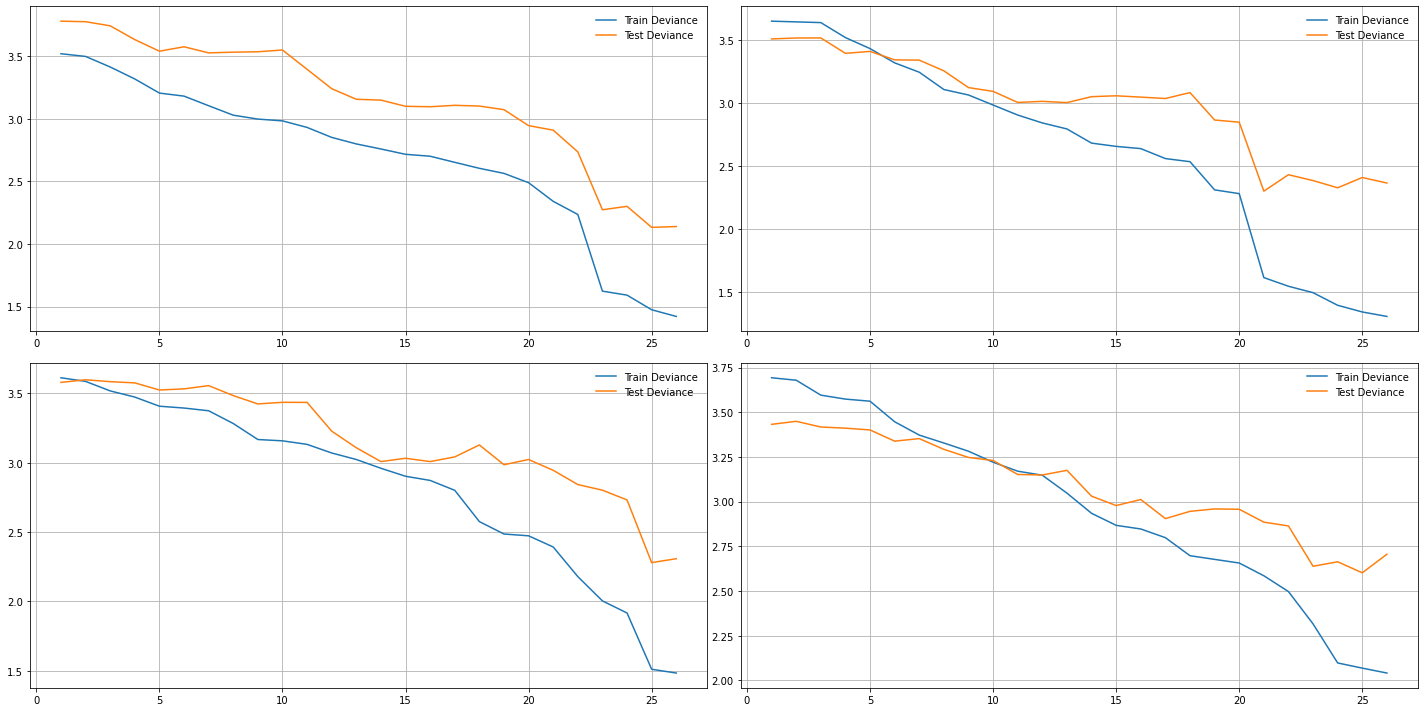

In [17]:
plt.figure(figsize=(20,10))
for i in range(4):
  plot_dev(dev_mat[i])

For the first plot, both the lines are maintaining almost similar distance throughout the graph. For plot 2, they are closer for max_depth between 5-12. For plot 3, these are 12-15 and for the last plot, it is 7-13. So, we can choose max_depth=12.

# Constructing the tree with max_depth=12

In [21]:
regressor = DecisionTreeRegressor(criterion='poisson',max_depth=12)
model = regressor.fit(X_train,y_train)

# Extracting the business rules from the tree

In [22]:
text_representation = tree.export_text(regressor,feature_names=list(X.columns))
print(text_representation)

|--- arr(h-13) <= 13.00
|   |--- arr(h-3) <= 12.50
|   |   |--- arr(h-14) <= 10.50
|   |   |   |--- arr(h-2) <= 12.50
|   |   |   |   |--- arr(h-11) <= 13.50
|   |   |   |   |   |--- arr(h-28) <= 9.50
|   |   |   |   |   |   |--- arr(h-1) <= 10.50
|   |   |   |   |   |   |   |--- arr(h-1) <= 9.50
|   |   |   |   |   |   |   |   |--- arr(h-13) <= 10.50
|   |   |   |   |   |   |   |   |   |--- arr(h-26) <= 10.50
|   |   |   |   |   |   |   |   |   |   |--- arr(h-13) <= 9.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- arr(h-13) >  9.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- arr(h-26) >  10.50
|   |   |   |   |   |   |   |   |   |   |--- arr(h-2) <= 3.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- arr(h-2) >  3.00
|   |   |   |   |   |   |   |   |   |   |   |

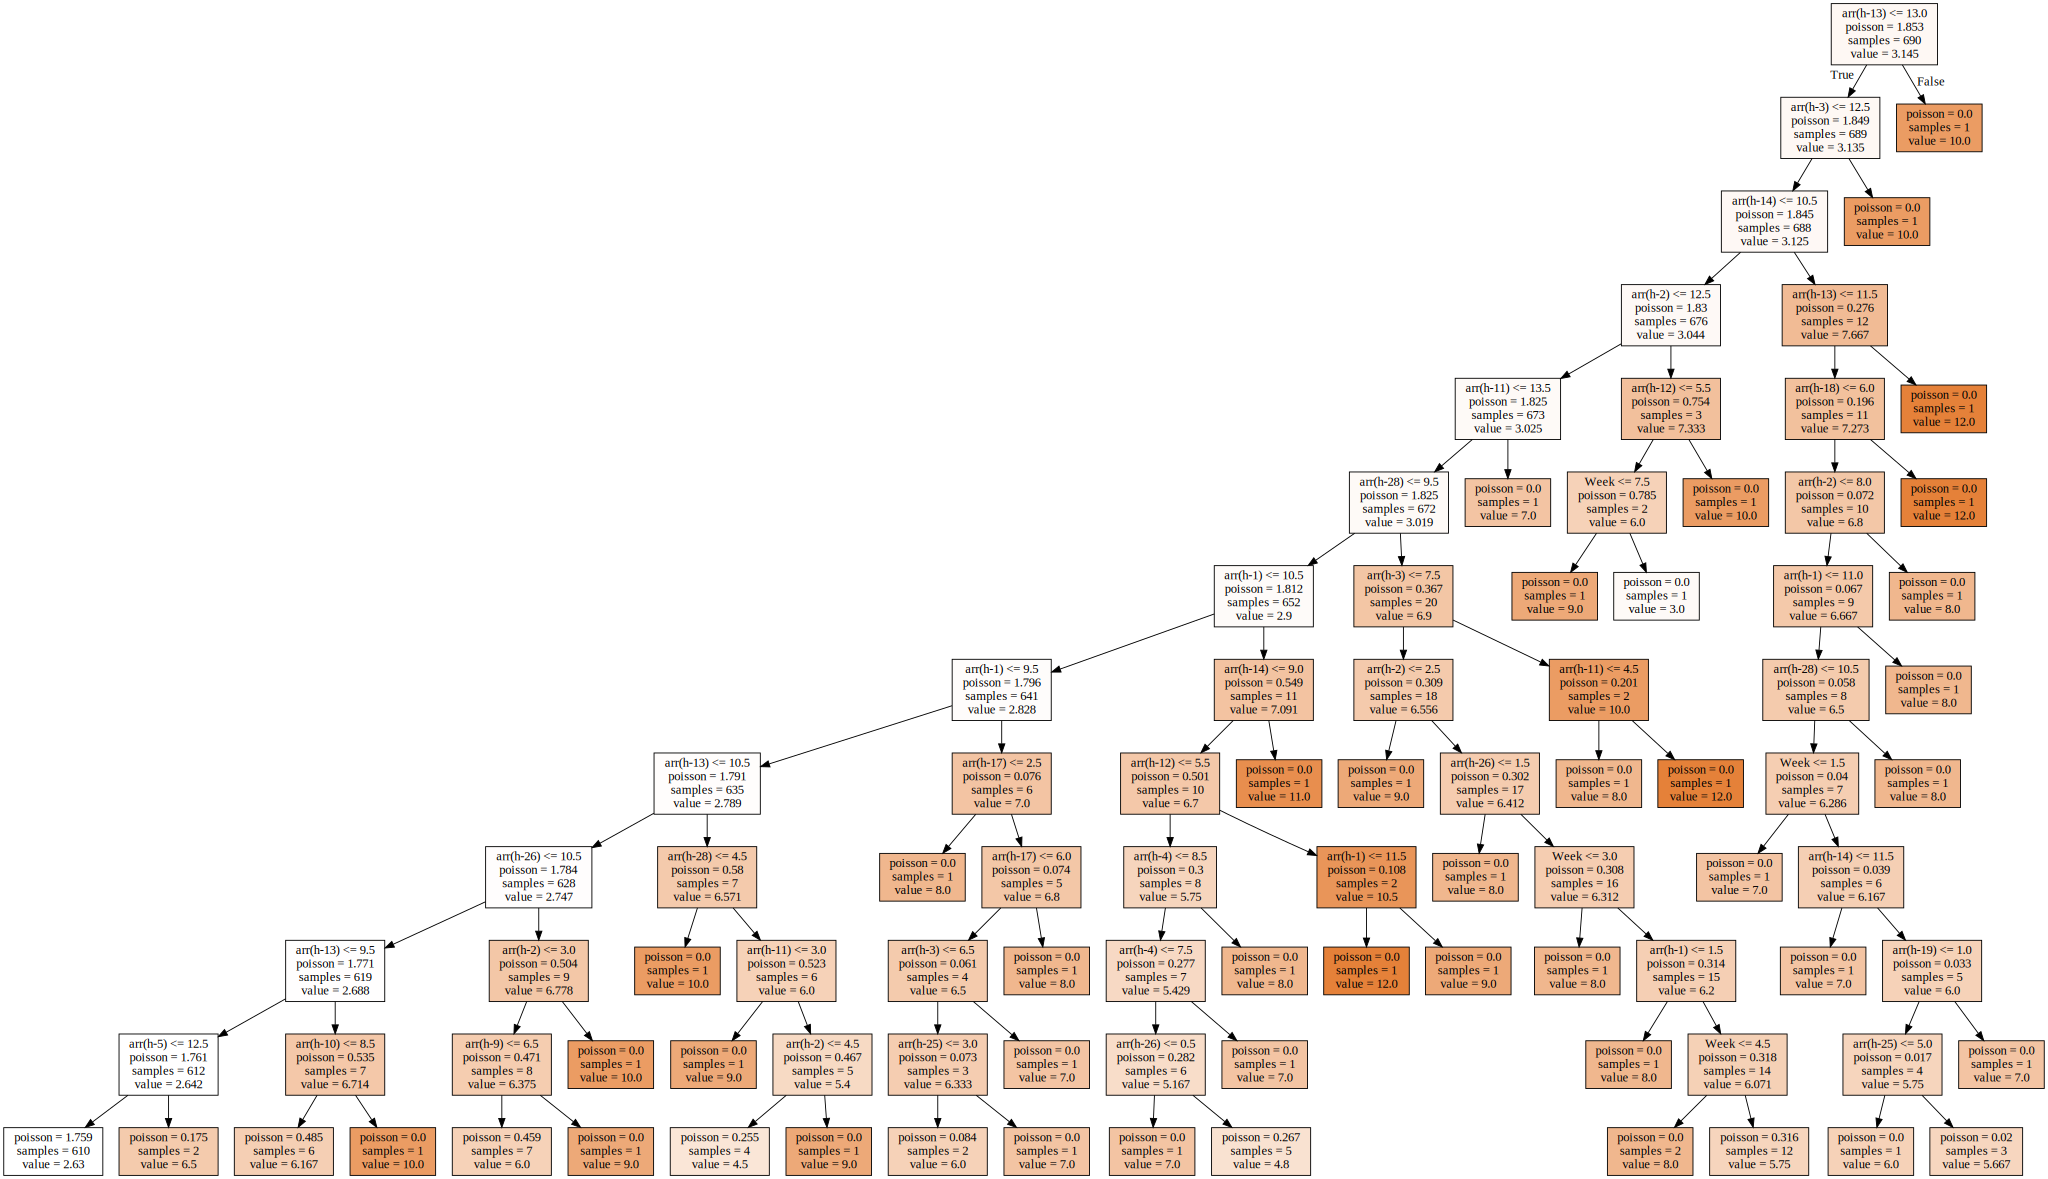

In [23]:
dot_data = tree.export_graphviz(regressor, out_file=None, 
                                feature_names=X.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png") 